In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from me0.data.datasets.index import ME0IndexDataset
from me0.modules.transformer.model import ME0Transformer
from me0.losses import ME0BCELoss

torch.set_num_threads(5)

In [2]:
model = ME0Transformer(
    dim_input = 5, # [ieta, layer, strip, cls, bx]
    num_layers = 4,
    dim_model = 128,
    num_heads = 8,
    dim_feedforward = 512,
    layer_norm_eps=1.0e-5,
    dropout=0.0,
    activation = "gelu",
    norm_first = True,
    bias = False,
).to_tensor_dict_module().eval()

state_dict = torch.load("../data/ME0Transformer_state_dict.pt", map_location='cpu')

model.load_state_dict(state_dict)

/users/yeonju/micromamba/envs/ME0SegReco-py311/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


<All keys matched successfully>

In [3]:
dataset = ME0IndexDataset(
    file='../data/step4_0.h5',
    features={
        'cls': {'min': 1, 'max': 384},
        'bx': {'min': -3, 'max': 3},
    },
)

test_loader = DataLoader(dataset[-1280:], collate_fn=dataset.collate, shuffle=False, drop_last=True, batch_size=128)

processing 35430 events:   0%|                                                                                                                        | 1/35430 [00:07<71:41:42,  7.29s/it]


In [4]:
loss_fn = ME0BCELoss(pos_weight=74.77, reduction='mean1').to_tensor_dict_module()

batch = next(iter(test_loader))

with torch.inference_mode():
    output = model(batch)
    loss = loss_fn(output)['loss']
    
print(loss)

tensor(0.0083)


In [5]:
from me0.postprocessing.clustering import SegmentEfficiency, SegmentFakeRate
from me0.postprocessing.clustering_graph import SegmentEfficiencyGraph, SegmentFakeRateGraph
from torchmetrics import MetricCollection

In [6]:
init_args = {
    'hit_threshold': 0.5,
    'min_hit_ratio': 0.6,
    'min_matched_layers': 4,
    'max_delta_strip': 2,
    'max_delta_layer': 3,
    'max_delta_ieta': 1,
}

seg_metrics = {
    'seg_eff': SegmentEfficiency(**init_args),
    'seg_fkrt': SegmentFakeRate(**init_args),
    'seg_eff_pt': SegmentEfficiencyGraph(
        edges = torch.arange(0, 55, 5),
        value = 'pt',
        **init_args,
    ),
    'seg_eff_ieta': SegmentEfficiencyGraph(
        edges = torch.arange(0.5, 9.5, 1),
        value = 'ieta',
        **init_args,
    ),
    'seg_fkrt_ieta': SegmentFakeRateGraph(
        edges = torch.arange(0.5, 9.5, 1),
        value = 'ieta',
        **init_args,
    ),
}

metric = MetricCollection(metrics=seg_metrics, compute_groups=False)

In [7]:
with torch.inference_mode():
    for batch in tqdm(test_loader):
        output = model(batch)
        metric.update(output)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]


In [8]:
metric.seg_eff.compute(), metric.seg_fkrt.compute()

(tensor(0.9920), tensor(0.1043))

In [9]:
metric.seg_eff_pt.numerator.sum() / metric.seg_eff_pt.denominator.sum()

tensor(0.9920)

In [10]:
metric.seg_fkrt_ieta.numerator.sum() / metric.seg_fkrt_ieta.denominator.sum()

tensor(0.1043)

In [11]:
from me0.utils.plot import Plot

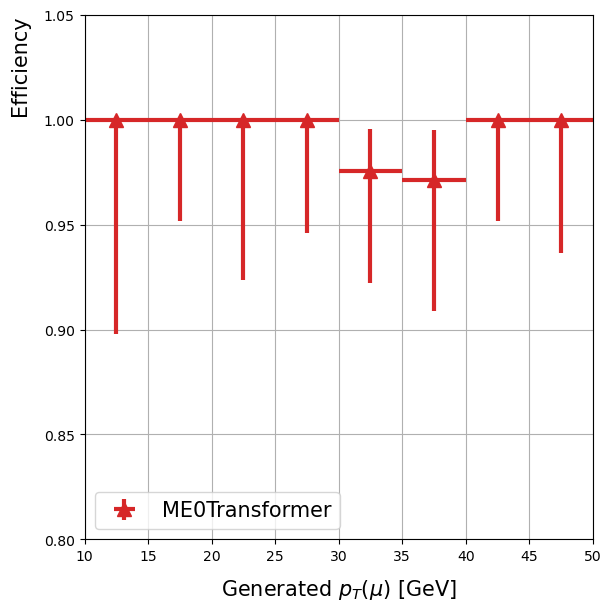

In [12]:
eff_pt = metric.seg_eff_pt

seg_eff_pt_plot = Plot(edges=eff_pt.edges, xlabel=r'Generated ${p_{T}(\mu)}$ [GeV]', ylabel='Efficiency')

seg_eff_pt_plot.add(
    num = eff_pt.numerator,
    denom = eff_pt.denominator,
    xlim = (10, 50),
    ylim = (0.8, 1.05),
    label = 'ME0Transformer',
    color = 'tab:red',
    marker = '^',
)

fig, ax = seg_eff_pt_plot.get_fig()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

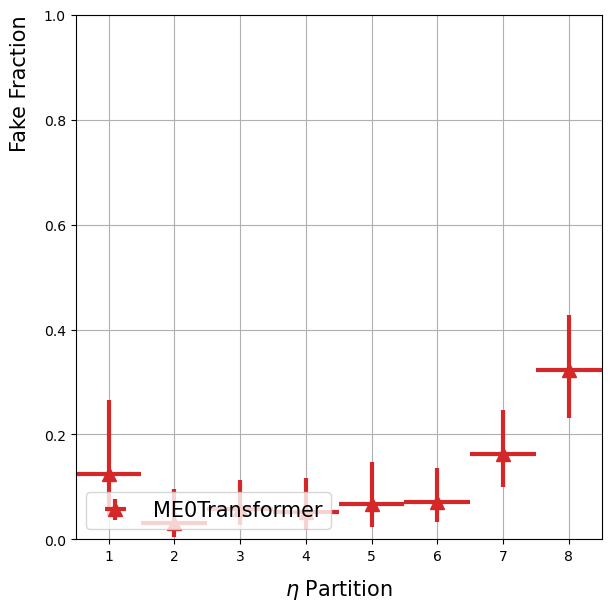

In [13]:
fkrt_ieta = metric.seg_fkrt_ieta

seg_fkrt_ieta_plot = Plot(edges=fkrt_ieta.edges, xlabel=r'$\eta$ Partition', ylabel='Fake Fraction')

seg_fkrt_ieta_plot.add(
    num = fkrt_ieta.numerator,
    denom = fkrt_ieta.denominator,
    xlim = (0.5, 8.5),
    ylim = (0.0, 1.0),
    label = 'ME0Transformer',
    color = 'tab:red',
    marker = '^',
)

fig, ax = seg_fkrt_ieta_plot.get_fig()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))